In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import os
from scipy import stats

# ตั้งค่า matplotlib ตามที่ระบุ
font = {'size': 16}
plt.rc('font', **font)

In [2]:
# ฟังก์ชันคำนวณการเปลี่ยนแปลงราคาในหน้าต่างเวลา
def calculate_price_changes(data, windows=[6, 12, 24]):
    price_changes = {}
    for window in windows:
        changes = []
        for i in range(len(data) - window):
            close_price = data['close'].iloc[i]
            high_price = data['high'].iloc[i:i+window].max()
            low_price = data['low'].iloc[i:i+window].min()
            # คำนวณ % การเปลี่ยนแปลงของราคา
            pct_change = (high_price - close_price) / close_price * 100
            # ตรวจสอบว่า low ไม่ต่ำกว่าราคาเริ่มต้นเกิน 3%
            if (low_price - close_price) / close_price > -0.03:
                changes.append({
                    'start_time': data.index[i],
                    'pct_change': pct_change,
                    'window': window
                })
        price_changes[window] = pd.DataFrame(changes)
    return price_changes

In [3]:
# ฟังก์ชันตรวจจับ Moonshot ด้วยเกณฑ์ที่กำหนด
def detect_moonshot(data, window=12, threshold=0.10):
    moonshots = []
    for i in range(len(data) - window):
        if moonshots and (data.index[i] - moonshots[-1]['start_time']).total_seconds() / 3600 < window:
            continue  # ข้ามถ้า Moonshot ใหม่เริ่มภายใน window ชั่วโมงจากครั้งก่อน
        close_price = data['close'].iloc[i]
        high_price = data['high'].iloc[i:i+window].max()
        low_price = data['low'].iloc[i:i+window].min()
        moonshot_pct = (high_price - close_price) / close_price
        # เงื่อนไข: ราคาขึ้น >= threshold และ low ไม่ลดเกิน 3%
        if moonshot_pct >= threshold and (low_price - close_price) / close_price > -0.03:
            moonshots.append({
                'start_time': data.index[i],
                'close_price': close_price,
                'high_price': high_price,
                'moonshot_pct': moonshot_pct * 100,
                'window_end_time': data.index[i+window-1]
            })
    return pd.DataFrame(moonshots)

In [4]:
# อ่านข้อมูลจากไฟล์ pickle
data = pd.read_pickle(os.path.abspath("../datasets/processed/1h/BTCUSDT.pkl"))
# ตั้ง index เป็น DatetimeIndex ถ้ายังไม่ได้ตั้ง
if not isinstance(data.index, pd.DatetimeIndex):
    data.index = pd.to_datetime(data['time'])
data = data[['open', 'high', 'low', 'close']]  # เลือกคอลัมน์ที่จำเป็น

In [5]:
# 1. คำนวณการเปลี่ยนแปลงของราคาในหน้าต่างเวลา 6, 12, 24 ชั่วโมง
windows = [6, 12, 24]
price_changes = calculate_price_changes(data, windows)

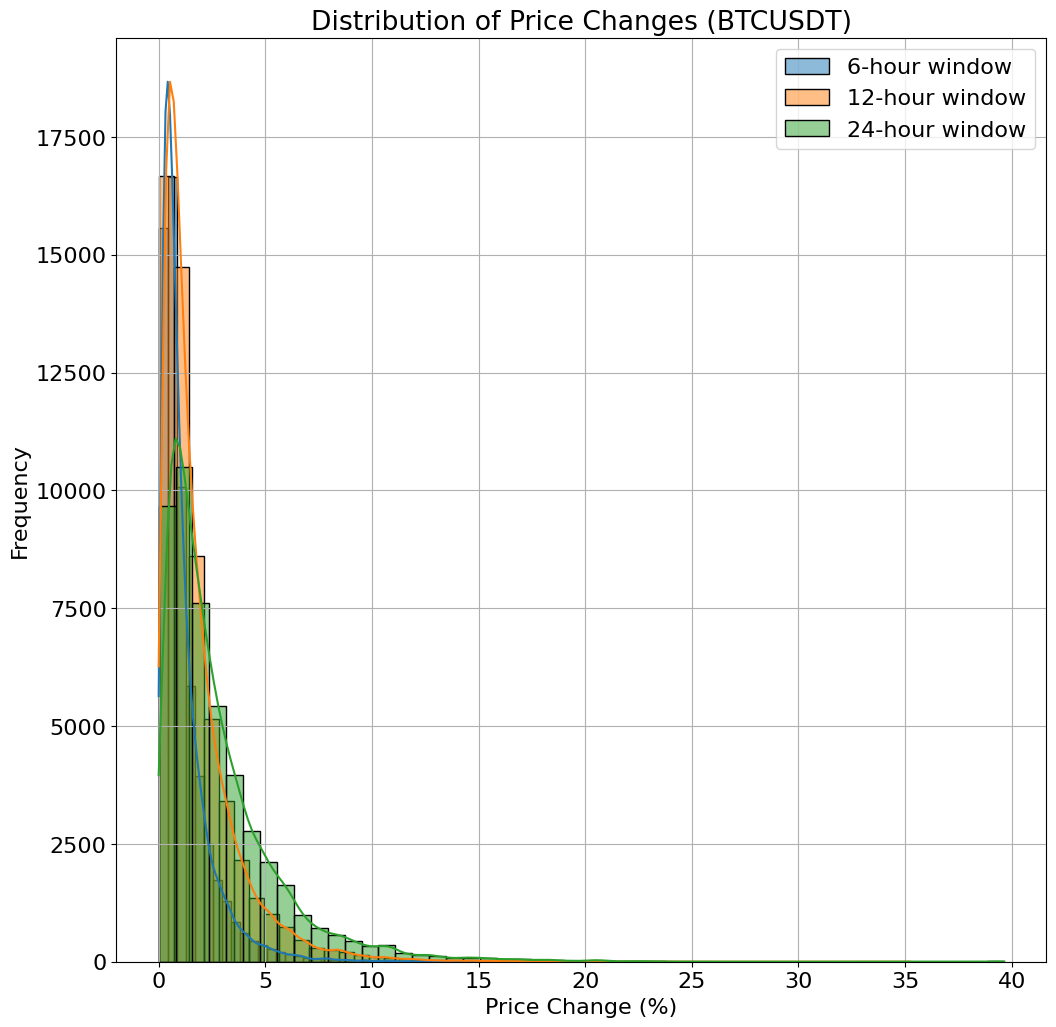

In [6]:
# 2. แสดงการแจกแจงของการเปลี่ยนแปลงราคา
plt.figure(figsize=(12, 12))
for window in windows:
    df = price_changes[window]
    sns.histplot(df['pct_change'], bins=50, kde=True, label=f'{window}-hour window', alpha=0.5)
plt.title('Distribution of Price Changes (BTCUSDT)')
plt.xlabel('Price Change (%)')
plt.ylabel('Frequency')
plt.legend()
plt.grid(True)
plt.show()

In [7]:
# 3. สรุปสถิติและ percentile สำหรับแต่ละหน้าต่าง
for window in windows:
    df = price_changes[window]
    print(f"\nStatistics for {window}-hour window:")
    print(f"Mean Price Change: {df['pct_change'].mean():.2f}%")
    print(f"Std Price Change: {df['pct_change'].std():.2f}%")
    print(f"Median Price Change: {df['pct_change'].median():.2f}%")
    print(f"95th Percentile: {df['pct_change'].quantile(0.95):.2f}%")
    print(f"99th Percentile: {df['pct_change'].quantile(0.99):.2f}%")
    
    # ทดสอบความปกติของการแจกแจง
    stat, p_value = stats.shapiro(df['pct_change'].sample(min(5000, len(df))))
    print(f"Shapiro-Wilk Test: stat={stat:.4f}, p-value={p_value:.4f}")
    if p_value < 0.05:
        print("The distribution is not normal (p < 0.05)")
    else:
        print("The distribution is normal (p >= 0.05)")


Statistics for 6-hour window:
Mean Price Change: 1.20%
Std Price Change: 1.33%
Median Price Change: 0.80%
95th Percentile: 3.58%
99th Percentile: 6.39%
Shapiro-Wilk Test: stat=0.6863, p-value=0.0000
The distribution is not normal (p < 0.05)

Statistics for 12-hour window:
Mean Price Change: 1.81%
Std Price Change: 1.93%
Median Price Change: 1.20%
95th Percentile: 5.43%
99th Percentile: 9.29%
Shapiro-Wilk Test: stat=0.7165, p-value=0.0000
The distribution is not normal (p < 0.05)

Statistics for 24-hour window:
Mean Price Change: 2.83%
Std Price Change: 2.87%
Median Price Change: 1.96%
95th Percentile: 8.29%
99th Percentile: 14.15%
Shapiro-Wilk Test: stat=0.7559, p-value=0.0000
The distribution is not normal (p < 0.05)


In [8]:
# 4. ทดสอบเกณฑ์ Moonshot ต่างๆ
thresholds = [0.05, 0.10, 0.15]  # 5%, 10%, 15%
results = []
for window in windows:
    for threshold in thresholds:
        moonshots = detect_moonshot(data, window=window, threshold=threshold)
        results.append({
            'window': window,
            'threshold': threshold * 100,
            'num_moonshots': len(moonshots),
            'mean_moonshot_size': moonshots['moonshot_pct'].mean() if not moonshots.empty else np.nan,
            'median_moonshot_size': moonshots['moonshot_pct'].median() if not moonshots.empty else np.nan
        })
results = pd.DataFrame(results)
print("\nMoonshot Detection Results:")
print(results)


Moonshot Detection Results:
   window  threshold  num_moonshots  mean_moonshot_size  median_moonshot_size
0       6        5.0            503            6.636649              5.851839
1       6       10.0             61           12.541458             11.644096
2       6       15.0             15           16.869348             16.057024
3      12        5.0            634            6.803936              5.829184
4      12       10.0            107           12.685570             11.535166
5      12       15.0             23           18.423948             17.213842
6      24        5.0            675            7.231703              5.877780
7      24       10.0            165           12.777091             11.109622
8      24       15.0             49           18.374516             17.312814


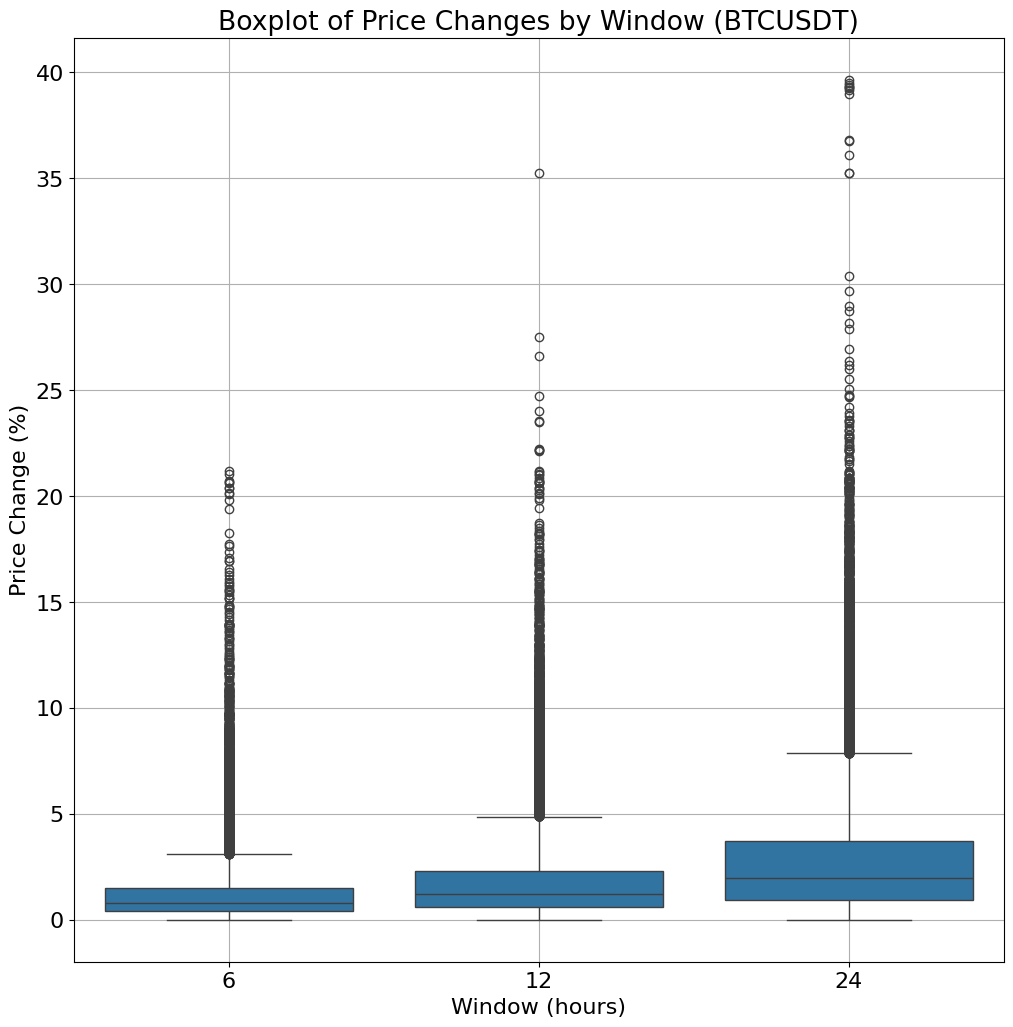

In [9]:
# 5. Boxplot ของการเปลี่ยนแปลงราคา
plt.figure(figsize=(12, 12))
sns.boxplot(x='window', y='pct_change', data=pd.concat(
    [price_changes[w].assign(window=w) for w in windows]))
plt.title('Boxplot of Price Changes by Window (BTCUSDT)')
plt.xlabel('Window (hours)')
plt.ylabel('Price Change (%)')
plt.grid(True)
plt.show()